In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [21]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

base_dir = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav' 

emotion_map = {
    'W': 'anger',        # Ärger (Wut)
    'F': 'happiness',    # Freude
    'T': 'sadness',      # Trauer
    'N': 'neutral'       # Neutral
}

def load_data_from_emodb(base_dir, emotion_map):
    data = []
    for filename in os.listdir(base_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(base_dir, filename)
            emotion_code = filename[5]  # Extracting the emotion character from filename
            if emotion_code in emotion_map:
                emotion = emotion_map[emotion_code]
                data.append({'file_path': file_path, 'emotion': emotion})
    return pd.DataFrame(data)

emodb_data = load_data_from_emodb(base_dir, emotion_map)

label_encoder = LabelEncoder()
emodb_data['label'] = label_encoder.fit_transform(emodb_data['emotion'])

train_data, test_data = train_test_split(emodb_data, test_size=0.1, random_state=42)

print(emodb_data.head())

                                           file_path    emotion  label
0  /kaggle/input/berlin-database-of-emotional-spe...  happiness      1
1  /kaggle/input/berlin-database-of-emotional-spe...  happiness      1
2  /kaggle/input/berlin-database-of-emotional-spe...      anger      0
3  /kaggle/input/berlin-database-of-emotional-spe...      anger      0
4  /kaggle/input/berlin-database-of-emotional-spe...      anger      0


In [22]:
unique_emo = emodb_df['label'].unique()
print(unique_emo)

[1 0 3 2]


In [23]:
class SERDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 2]
        audio, _ = librosa.load(file_path, sr=16000)
        processed_audio = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = processed_audio.input_values.squeeze(0)
        return input_values, torch.tensor(label)

In [24]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    max_length = max([inp.shape[0] for inp in inputs])
    padded_inputs = [torch.nn.functional.pad(inp, (0, max_length - inp.shape[0])) for inp in inputs]
    processed_inputs = torch.stack(padded_inputs)
    return processed_inputs, torch.tensor(labels)

In [25]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

train_dataset = SERDataset(train_data, processor)
test_dataset = SERDataset(test_data, processor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [26]:
print(inputs.shape)

NameError: name 'inputs' is not defined

In [27]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

train_accuracies = [] 
train_losses = []
val_losses = []
val_accuracies = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
num_epochs = 110
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    '''if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    scheduler.step(avg_val_loss)'''

print("Training complete!")


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.28it/s]


Epoch 1/110, Train Loss: 0.0339, Train Accuracy: 0.9967, Val Loss: 0.8518, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.44it/s]


Epoch 2/110, Train Loss: 0.0116, Train Accuracy: 1.0000, Val Loss: 0.5486, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 59.51it/s]


Epoch 3/110, Train Loss: 0.0128, Train Accuracy: 1.0000, Val Loss: 0.4215, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.57it/s]


Epoch 4/110, Train Loss: 0.0278, Train Accuracy: 0.9967, Val Loss: 0.2570, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.24it/s]


Epoch 5/110, Train Loss: 0.0040, Train Accuracy: 1.0000, Val Loss: 0.2423, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.95it/s]


Epoch 6/110, Train Loss: 0.0181, Train Accuracy: 0.9967, Val Loss: 0.0287, Val Accuracy: 0.9706


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.58it/s]


Epoch 7/110, Train Loss: 0.0107, Train Accuracy: 0.9967, Val Loss: 0.7306, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.14it/s]


Epoch 8/110, Train Loss: 0.0319, Train Accuracy: 0.9934, Val Loss: 0.1835, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.15it/s]


Epoch 9/110, Train Loss: 0.0129, Train Accuracy: 0.9967, Val Loss: 0.1924, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.52it/s]


Epoch 10/110, Train Loss: 0.0063, Train Accuracy: 1.0000, Val Loss: 0.2015, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.60it/s]


Epoch 11/110, Train Loss: 0.0242, Train Accuracy: 0.9967, Val Loss: 0.2207, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.95it/s]


Epoch 12/110, Train Loss: 0.0071, Train Accuracy: 1.0000, Val Loss: 0.2432, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.44it/s]


Epoch 13/110, Train Loss: 0.0185, Train Accuracy: 0.9967, Val Loss: 0.0225, Val Accuracy: 1.0000


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.61it/s]


Epoch 14/110, Train Loss: 0.0111, Train Accuracy: 0.9967, Val Loss: 0.3106, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.71it/s]


Epoch 15/110, Train Loss: 0.0160, Train Accuracy: 0.9967, Val Loss: 0.7161, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.77it/s]


Epoch 16/110, Train Loss: 0.0046, Train Accuracy: 1.0000, Val Loss: 0.4109, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.75it/s]


Epoch 17/110, Train Loss: 0.0080, Train Accuracy: 1.0000, Val Loss: 0.3912, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.58it/s]


Epoch 18/110, Train Loss: 0.0051, Train Accuracy: 1.0000, Val Loss: 0.3809, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.37it/s]


Epoch 19/110, Train Loss: 0.0050, Train Accuracy: 1.0000, Val Loss: 0.3795, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.52it/s]


Epoch 20/110, Train Loss: 0.0197, Train Accuracy: 0.9967, Val Loss: 0.3476, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.06it/s]


Epoch 21/110, Train Loss: 0.0220, Train Accuracy: 0.9934, Val Loss: 0.7803, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.28it/s]


Epoch 22/110, Train Loss: 0.0336, Train Accuracy: 0.9934, Val Loss: 0.2163, Val Accuracy: 0.9706


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.45it/s]


Epoch 23/110, Train Loss: 0.0151, Train Accuracy: 0.9967, Val Loss: 0.2441, Val Accuracy: 0.9706


Validation: 100%|██████████| 34/34 [00:00<00:00, 58.96it/s]


Epoch 24/110, Train Loss: 0.0115, Train Accuracy: 0.9934, Val Loss: 0.2552, Val Accuracy: 0.9706


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.77it/s]


Epoch 25/110, Train Loss: 0.0050, Train Accuracy: 0.9967, Val Loss: 0.7046, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.66it/s]


Epoch 26/110, Train Loss: 0.0053, Train Accuracy: 0.9967, Val Loss: 0.8179, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.62it/s]


Epoch 27/110, Train Loss: 0.0149, Train Accuracy: 1.0000, Val Loss: 0.5352, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.47it/s]


Epoch 28/110, Train Loss: 0.0102, Train Accuracy: 0.9967, Val Loss: 0.9257, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.36it/s]


Epoch 29/110, Train Loss: 0.0097, Train Accuracy: 1.0000, Val Loss: 0.2915, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.25it/s]


Epoch 30/110, Train Loss: 0.0045, Train Accuracy: 0.9967, Val Loss: 0.5145, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.44it/s]


Epoch 31/110, Train Loss: 0.0068, Train Accuracy: 1.0000, Val Loss: 0.4262, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 57.78it/s]


Epoch 32/110, Train Loss: 0.0227, Train Accuracy: 0.9902, Val Loss: 0.8709, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.84it/s]


Epoch 33/110, Train Loss: 0.0770, Train Accuracy: 0.9738, Val Loss: 0.5012, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.93it/s]


Epoch 34/110, Train Loss: 0.0073, Train Accuracy: 1.0000, Val Loss: 0.6148, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.20it/s]


Epoch 35/110, Train Loss: 0.0514, Train Accuracy: 0.9902, Val Loss: 0.7308, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.17it/s]


Epoch 36/110, Train Loss: 0.0225, Train Accuracy: 0.9902, Val Loss: 0.8534, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.16it/s]


Epoch 37/110, Train Loss: 0.0078, Train Accuracy: 1.0000, Val Loss: 0.7768, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.86it/s]


Epoch 38/110, Train Loss: 0.0167, Train Accuracy: 0.9967, Val Loss: 1.0208, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 57.33it/s]


Epoch 39/110, Train Loss: 0.0169, Train Accuracy: 0.9934, Val Loss: 0.4614, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.06it/s]


Epoch 40/110, Train Loss: 0.0101, Train Accuracy: 0.9967, Val Loss: 0.3147, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.88it/s]


Epoch 41/110, Train Loss: 0.0429, Train Accuracy: 0.9934, Val Loss: 0.6295, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.05it/s]


Epoch 42/110, Train Loss: 0.0031, Train Accuracy: 1.0000, Val Loss: 0.6521, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.34it/s]


Epoch 43/110, Train Loss: 0.0039, Train Accuracy: 1.0000, Val Loss: 0.6760, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.22it/s]


Epoch 44/110, Train Loss: 0.0280, Train Accuracy: 0.9967, Val Loss: 0.4428, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.37it/s]


Epoch 45/110, Train Loss: 0.0026, Train Accuracy: 1.0000, Val Loss: 0.3832, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.79it/s]


Epoch 46/110, Train Loss: 0.2242, Train Accuracy: 0.9869, Val Loss: 0.4745, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.54it/s]


Epoch 47/110, Train Loss: 0.0228, Train Accuracy: 0.9967, Val Loss: 0.2235, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.12it/s]


Epoch 48/110, Train Loss: 0.0164, Train Accuracy: 1.0000, Val Loss: 0.3883, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.61it/s]


Epoch 49/110, Train Loss: 0.0217, Train Accuracy: 1.0000, Val Loss: 0.4064, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.16it/s]


Epoch 50/110, Train Loss: 0.0036, Train Accuracy: 1.0000, Val Loss: 0.4345, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.50it/s]


Epoch 51/110, Train Loss: 0.0142, Train Accuracy: 0.9934, Val Loss: 0.2786, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.99it/s]


Epoch 52/110, Train Loss: 0.0164, Train Accuracy: 0.9934, Val Loss: 0.7685, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.36it/s]


Epoch 53/110, Train Loss: 0.0218, Train Accuracy: 0.9934, Val Loss: 0.3994, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.34it/s]


Epoch 54/110, Train Loss: 0.0053, Train Accuracy: 1.0000, Val Loss: 0.6811, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.82it/s]


Epoch 55/110, Train Loss: 0.0083, Train Accuracy: 0.9967, Val Loss: 0.7061, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.68it/s]


Epoch 56/110, Train Loss: 0.0197, Train Accuracy: 0.9967, Val Loss: 0.6928, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.12it/s]


Epoch 57/110, Train Loss: 0.0668, Train Accuracy: 0.9902, Val Loss: 0.6753, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.79it/s]


Epoch 58/110, Train Loss: 0.0399, Train Accuracy: 0.9934, Val Loss: 0.3674, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.41it/s]


Epoch 59/110, Train Loss: 0.0061, Train Accuracy: 1.0000, Val Loss: 0.6583, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.09it/s]


Epoch 60/110, Train Loss: 0.0118, Train Accuracy: 0.9967, Val Loss: 0.9899, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.31it/s]


Epoch 61/110, Train Loss: 0.0231, Train Accuracy: 0.9934, Val Loss: 0.3514, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 60.02it/s]


Epoch 62/110, Train Loss: 0.0227, Train Accuracy: 0.9967, Val Loss: 0.5485, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.42it/s]


Epoch 63/110, Train Loss: 0.0179, Train Accuracy: 0.9967, Val Loss: 0.4334, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.02it/s]


Epoch 64/110, Train Loss: 0.0836, Train Accuracy: 0.9869, Val Loss: 0.4321, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.28it/s]


Epoch 65/110, Train Loss: 0.0131, Train Accuracy: 0.9934, Val Loss: 0.5132, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.66it/s]


Epoch 66/110, Train Loss: 0.0026, Train Accuracy: 1.0000, Val Loss: 0.5551, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.52it/s]


Epoch 67/110, Train Loss: 0.0767, Train Accuracy: 0.9902, Val Loss: 0.3240, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.42it/s]


Epoch 68/110, Train Loss: 0.0029, Train Accuracy: 1.0000, Val Loss: 0.2845, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.13it/s]


Epoch 69/110, Train Loss: 0.0022, Train Accuracy: 1.0000, Val Loss: 0.2977, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.34it/s]


Epoch 70/110, Train Loss: 0.0113, Train Accuracy: 0.9967, Val Loss: 0.3055, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 60.38it/s]


Epoch 71/110, Train Loss: 0.0137, Train Accuracy: 1.0000, Val Loss: 0.3109, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.24it/s]


Epoch 72/110, Train Loss: 0.0031, Train Accuracy: 1.0000, Val Loss: 0.3146, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.97it/s]


Epoch 73/110, Train Loss: 0.0034, Train Accuracy: 1.0000, Val Loss: 0.4473, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.21it/s]


Epoch 74/110, Train Loss: 0.0025, Train Accuracy: 1.0000, Val Loss: 0.6433, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.96it/s]


Epoch 75/110, Train Loss: 0.0019, Train Accuracy: 1.0000, Val Loss: 0.6735, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.42it/s]


Epoch 76/110, Train Loss: 0.0020, Train Accuracy: 1.0000, Val Loss: 0.6723, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.34it/s]


Epoch 77/110, Train Loss: 0.0015, Train Accuracy: 1.0000, Val Loss: 0.6721, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.15it/s]


Epoch 78/110, Train Loss: 0.0043, Train Accuracy: 1.0000, Val Loss: 0.6591, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.32it/s]


Epoch 79/110, Train Loss: 0.0015, Train Accuracy: 1.0000, Val Loss: 0.6563, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.86it/s]


Epoch 80/110, Train Loss: 0.0015, Train Accuracy: 1.0000, Val Loss: 0.6548, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 60.83it/s]


Epoch 81/110, Train Loss: 0.0032, Train Accuracy: 1.0000, Val Loss: 0.6165, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.70it/s]


Epoch 82/110, Train Loss: 0.0013, Train Accuracy: 1.0000, Val Loss: 0.6143, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.69it/s]


Epoch 83/110, Train Loss: 0.0018, Train Accuracy: 1.0000, Val Loss: 0.6170, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 60.55it/s]


Epoch 84/110, Train Loss: 0.0166, Train Accuracy: 0.9934, Val Loss: 0.7682, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 60.98it/s]


Epoch 85/110, Train Loss: 0.0253, Train Accuracy: 0.9967, Val Loss: 0.2715, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.10it/s]


Epoch 86/110, Train Loss: 0.0036, Train Accuracy: 1.0000, Val Loss: 0.2097, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.51it/s]


Epoch 87/110, Train Loss: 0.0210, Train Accuracy: 0.9902, Val Loss: 0.2150, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.23it/s]


Epoch 88/110, Train Loss: 0.0163, Train Accuracy: 0.9902, Val Loss: 0.6287, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.71it/s]


Epoch 89/110, Train Loss: 0.0083, Train Accuracy: 1.0000, Val Loss: 0.6417, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.51it/s]


Epoch 90/110, Train Loss: 0.0726, Train Accuracy: 0.9902, Val Loss: 0.4760, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.50it/s]


Epoch 91/110, Train Loss: 0.1010, Train Accuracy: 0.9770, Val Loss: 0.8150, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.60it/s]


Epoch 92/110, Train Loss: 0.0106, Train Accuracy: 1.0000, Val Loss: 0.4494, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.31it/s]


Epoch 93/110, Train Loss: 0.0324, Train Accuracy: 0.9934, Val Loss: 0.6820, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.83it/s]


Epoch 94/110, Train Loss: 0.0600, Train Accuracy: 0.9836, Val Loss: 0.0039, Val Accuracy: 1.0000


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.16it/s]


Epoch 95/110, Train Loss: 0.0228, Train Accuracy: 0.9934, Val Loss: 0.5534, Val Accuracy: 0.8824


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.40it/s]


Epoch 96/110, Train Loss: 0.0029, Train Accuracy: 1.0000, Val Loss: 0.2760, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.58it/s]


Epoch 97/110, Train Loss: 0.0148, Train Accuracy: 1.0000, Val Loss: 0.3113, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.40it/s]


Epoch 98/110, Train Loss: 0.0068, Train Accuracy: 1.0000, Val Loss: 0.2862, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.20it/s]


Epoch 99/110, Train Loss: 0.0018, Train Accuracy: 1.0000, Val Loss: 0.3515, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.25it/s]


Epoch 100/110, Train Loss: 0.0205, Train Accuracy: 0.9934, Val Loss: 0.0674, Val Accuracy: 0.9706


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.71it/s]


Epoch 101/110, Train Loss: 0.0971, Train Accuracy: 0.9836, Val Loss: 0.2162, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 61.51it/s]


Epoch 102/110, Train Loss: 0.0127, Train Accuracy: 1.0000, Val Loss: 0.3232, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.28it/s]


Epoch 103/110, Train Loss: 0.0288, Train Accuracy: 0.9902, Val Loss: 0.9435, Val Accuracy: 0.8529


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.23it/s]


Epoch 104/110, Train Loss: 0.0328, Train Accuracy: 0.9934, Val Loss: 0.1175, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.24it/s]


Epoch 105/110, Train Loss: 0.0134, Train Accuracy: 0.9967, Val Loss: 0.2194, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.09it/s]


Epoch 106/110, Train Loss: 0.0238, Train Accuracy: 0.9967, Val Loss: 0.5900, Val Accuracy: 0.9118


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.73it/s]


Epoch 107/110, Train Loss: 0.0271, Train Accuracy: 0.9967, Val Loss: 0.2218, Val Accuracy: 0.9412


Validation: 100%|██████████| 34/34 [00:00<00:00, 63.61it/s]


Epoch 108/110, Train Loss: 0.0315, Train Accuracy: 0.9934, Val Loss: 0.1525, Val Accuracy: 0.9706


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.86it/s]


Epoch 109/110, Train Loss: 0.0076, Train Accuracy: 1.0000, Val Loss: 0.2126, Val Accuracy: 0.9706


Validation: 100%|██████████| 34/34 [00:00<00:00, 62.61it/s]

Epoch 110/110, Train Loss: 0.0019, Train Accuracy: 1.0000, Val Loss: 0.2221, Val Accuracy: 0.9706
Training complete!


In [34]:
torch.save(model.state_dict(), 'wav2vec_emodb_100.pth')

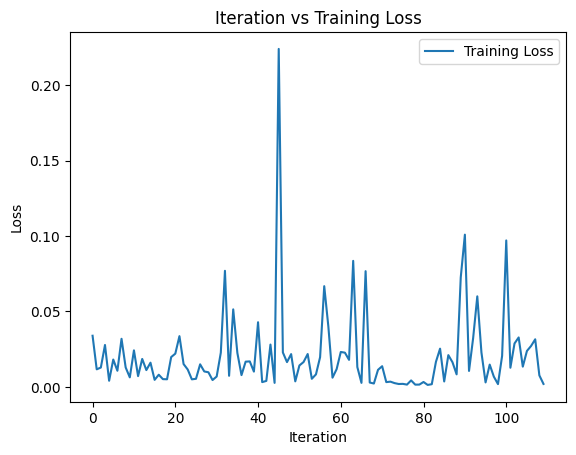

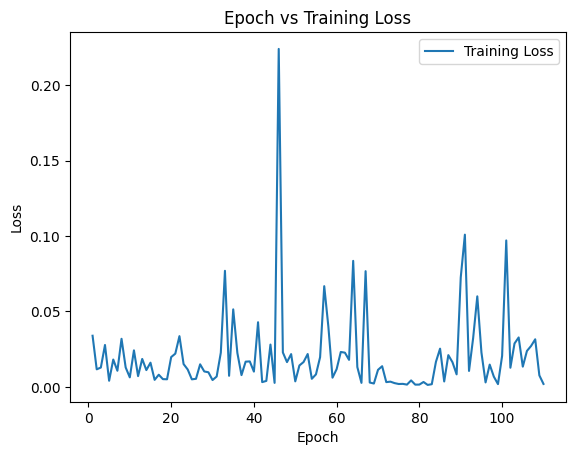

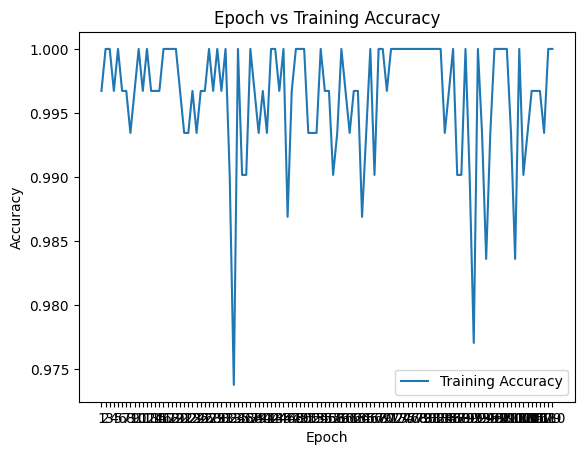

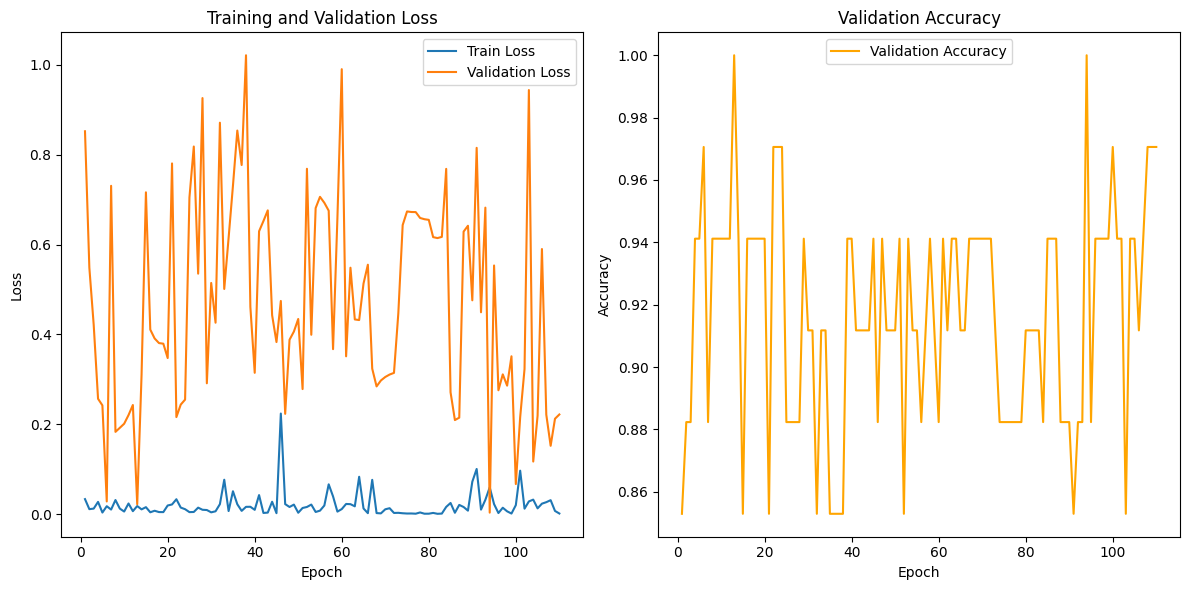

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Loss
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(1, len(train_accuracies) + 1)  # Epochs from 1 to the number of epochs
plt.plot(acc_X, train_accuracies, "-", label="Training Accuracy")
plt.xticks(acc_X)  # Ensures x-axis shows every epoch number
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()


In [42]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

# Assuming test_loader is already defined as a DataLoader for your test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
emotion_names = label_encoder.classes_
with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels": [], "predictions": []}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        # Assuming the input values are in the format of input_values and attention_mask
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        
        # Get predictions (assuming classification with argmax)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate correct predictions and total count
        correct += (preds == labels).sum().item()
        count += labels.size(0)
        
        # Calculate accuracy
        accuracy = correct / count
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        # Store the labels and predictions for classification report
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += preds.cpu().numpy().tolist()
        
    pbar.close()

    time.sleep(0.3)
    print(f"The final accuracy on the test dataset: {accuracy * 100:.4f}%")

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(record["labels"], record["predictions"], target_names=emotion_names, digits=4))


100%|██████████| 34/34 [00:00<00:00, 59.37it/s, loss=0.001, accuracy=0.971]


The final accuracy on the test dataset: 97.0588%

Classification Report:
              precision    recall  f1-score   support

       anger     0.9000    1.0000    0.9474         9
   happiness     1.0000    0.9000    0.9474        10
     neutral     1.0000    1.0000    1.0000        10
     sadness     1.0000    1.0000    1.0000         5

    accuracy                         0.9706        34
   macro avg     0.9750    0.9750    0.9737        34
weighted avg     0.9735    0.9706    0.9706        34



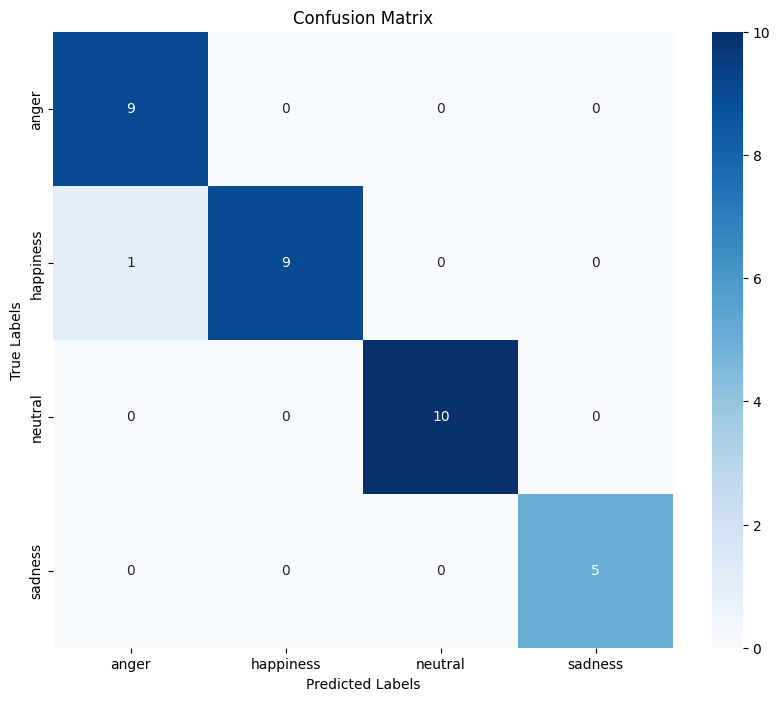

In [45]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d",xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()